In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline 

# Parte 1

In [2]:
#Dados coletados

#Posição y da sonda e da interface óleo-ar
y_oleo = 218/1000 #m
y_sonda = np.array([(218-i*10) for i in range(0,11)])/1000 #m

#Posição y dos tubos do manometro
y_esquerdo = np.array([120,113,111.5,106,102,98,94,88.5,82,76,71.5])/1000 #m
y_direito = np.array([120,126,130,133.5,138,143,146,151,155,161,165])/1000 #m


#Incertezas dos equipamentos
sigma_y = 5e-4 #m

## Calculando a profundidade em que se encontra a ponta do tubo e sua incerteza

Como $h = y_{oleo} - y_{sonda}$, então a incerteza de $h$ proveninete da propagação de erros das posições é:

$$\sigma_h = \sqrt{\sigma_{y_{oleo}}^2 + \sigma_{y_{sonda}}^2}$$

Ambos os valores de posição tem a mesma incerteza, pois foram medidos com a régua. Logo:

$$\sigma_h = \sigma_{regua}\sqrt{2}$$


In [3]:
#Calculando a profundidade da sonda
h = y_oleo - y_sonda
#Calculando a incerteza da profundidade e arredondando-a para um algarismo significativo
sigma_h = float('{:g}'.format(float('{:.1g}'.format(sigma_y*np.sqrt(2)))))
print(h, sigma_h)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ] 0.0007


## Calculando a diferença entre o y_direito e o y_esquerdo para obtermos a altura da coluna no manômetro


A pressão manométrica é igual a pressão gerada pela coluna de líquido do lado direito que está acima do y_esquerdo. Pela lei de Stevin nós temos que:

$$p_{man} = \rho_a g h_{man} = \rho_a g (y_{direito} - y_{esquerdo})$$

Propagando a incerteza das medidas de posição:

$$\sigma_{p_{man}} = \sqrt{\left(\frac{\partial \rho_a g (y_{direito} - y_{esquerdo})}{\partial y_{direito}}\right)^2 \sigma_{y_{direito}}^2 + \left(\frac{\partial \rho_a g (y_{direito} - y_{esquerdo})}{\partial y_{esquerdo}}\right)^2 \sigma_{y_{esquerdo}}^2}$$

Lembrando que $\sigma_{y_{esquerdo}} = \sigma_{y_{direito}} = \sigma_{regua}$:

$$\sigma_{p_{man}} = \sigma_{regua}\sqrt{\left( \rho_a g \right)^2 + \left(- \rho_a g \right)^2 }$$
$$\sigma_{p_{man}} = \rho_a g \sigma_{regua}\sqrt{2 }$$

In [4]:
#Densidade da água
rho_a = 1e3 #kg/m^3

#Aceleração da gravidade
g=9.8 #m/s^2

#Calculando a altura da coluna de líquido do tubo direito que está acima de y_{esquerdo}
h_man = y_direito - y_esquerdo #m

#Calculando a pressão manométrica
p_man = rho_a*g*h_man #Pa

#Calculando a incerteza da pressão manométrica e arredondando-a para um algarismo signficativo
sigma_p_man = float('{:g}'.format(float('{:.1g}'.format(rho_a*g*sigma_y*np.sqrt(2)))))

#Arredondando a pressão segundo a sua incerteza
p_man = np.round(p_man,-1)

print(p_man,sigma_p_man)

[  0. 130. 180. 270. 350. 440. 510. 610. 720. 830. 920.] 7.0


## Gráfico dos dados brutos

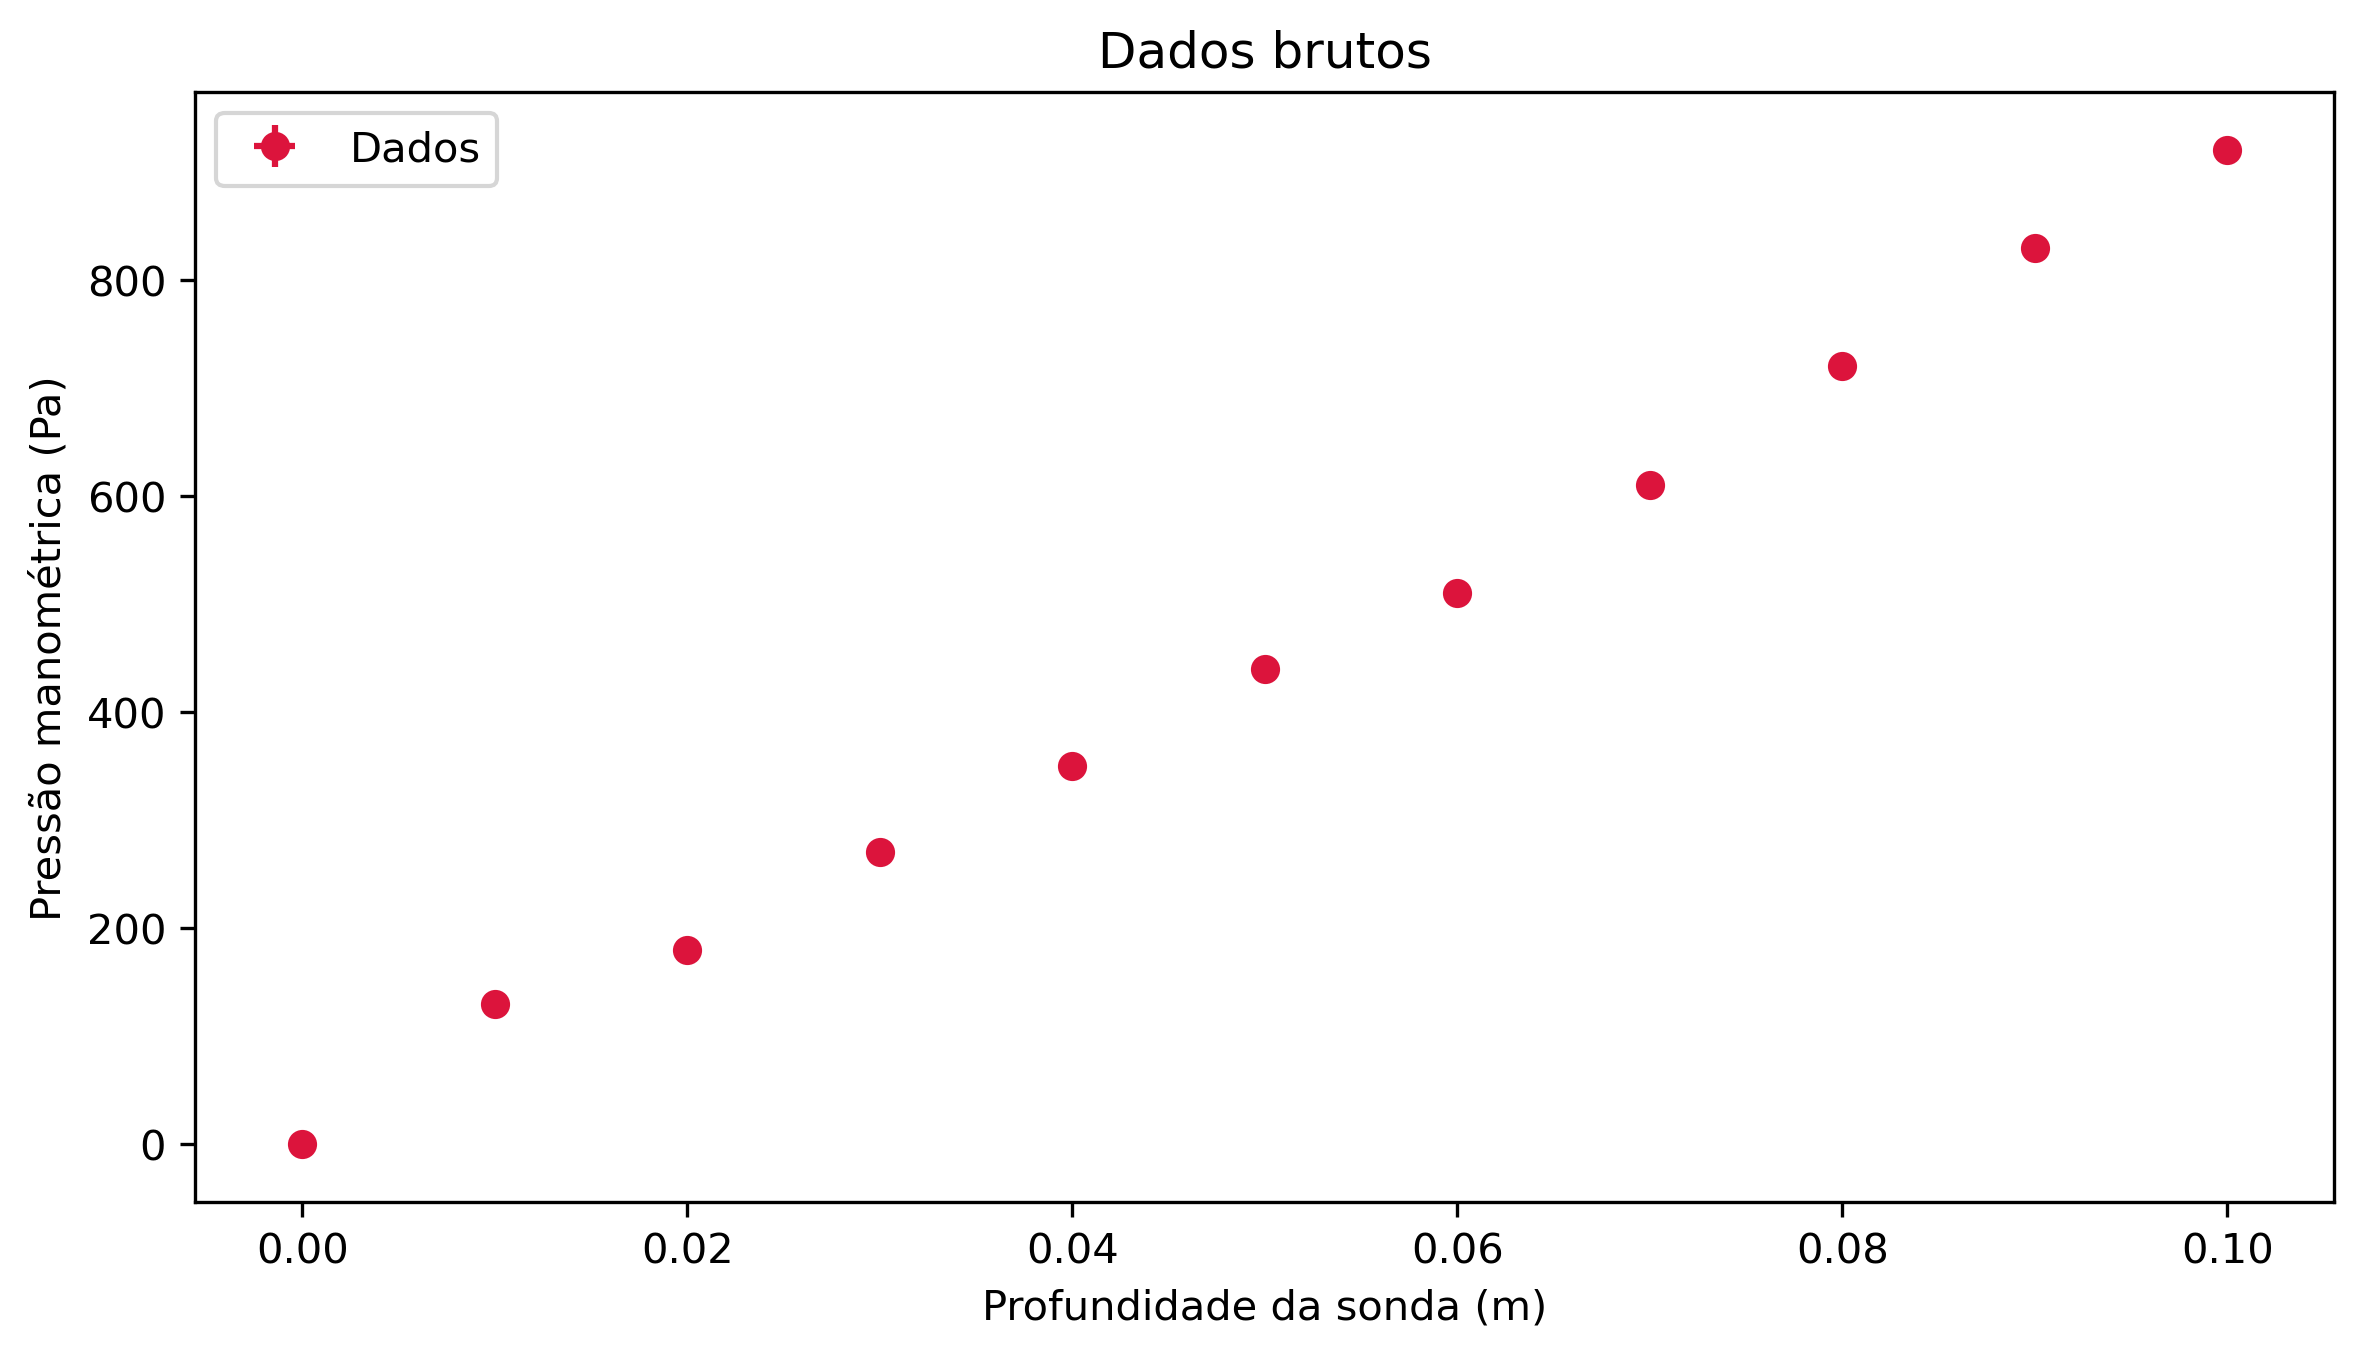

In [17]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(h,p_man,np.full(len(p_man),sigma_p_man),np.full(len(h),sigma_y), 'o', color = 'crimson', label = 'Dados')
plt.xlabel('Profundidade da sonda (m)')
plt.ylabel(r'Pressão manométrica (Pa)')
plt.title('Dados brutos')
plt.legend()
plt.savefig('P_manxh_brutos.pdf', dpi =300)
plt.show()

## Transferência de incerteza

In [6]:
#Realizando o fit sobre os dados brutos:

fit = np.polyfit(h, p_man,1)

sigma_p_man_transf = np.sqrt(np.power(sigma_p_man,2) + np.power(sigma_h*fit[0],2) )
sigma_p_man_transf = float('{:g}'.format(float('{:.1g}'.format(sigma_p_man_transf)))) 

print(sigma_p_man_transf)

9.0


## Calculando o ajuste linear (MMQ)

In [7]:
fitpars, cov_pars = np.polyfit(h,p_man,1,w=np.power(np.full(len(p_man),sigma_p_man_transf),-1),cov='True')
poly1d_fn = np.poly1d(fitpars) 
#print(fitpars, cov_pars)

#Coeficientes da reta ajustada:
coef_angular = fitpars[0]
coef_linear = fitpars[1]
sigma_angular = np.sqrt(cov_pars[0][0])
sigma_linear = np.sqrt(cov_pars[1][1])


#Considerando apenas um algarismo significativo na incerteza:
sigma_angular = float('{:g}'.format(float('{:.1g}'.format(sigma_angular))))
sigma_linear = float('{:g}'.format(float('{:.1g}'.format(sigma_linear))))

#Arredondando os coeficientes segundo sua incerteza:
coef_angular = np.round(coef_angular,-2)
coef_linear  = np.round(coef_linear,-1)
    
print('Coeficiente angular: %.0f +- %.0f (Pa/m)' % (coef_angular ,sigma_angular))
print('Coeficiente linear: %.0f +- %.0f (Pa)' %(coef_linear,sigma_linear))

Coeficiente angular: 9000 +- 200 (Pa/m)
Coeficiente linear: 0 +- 10 (Pa)


## Gráfico contendo o ajuste

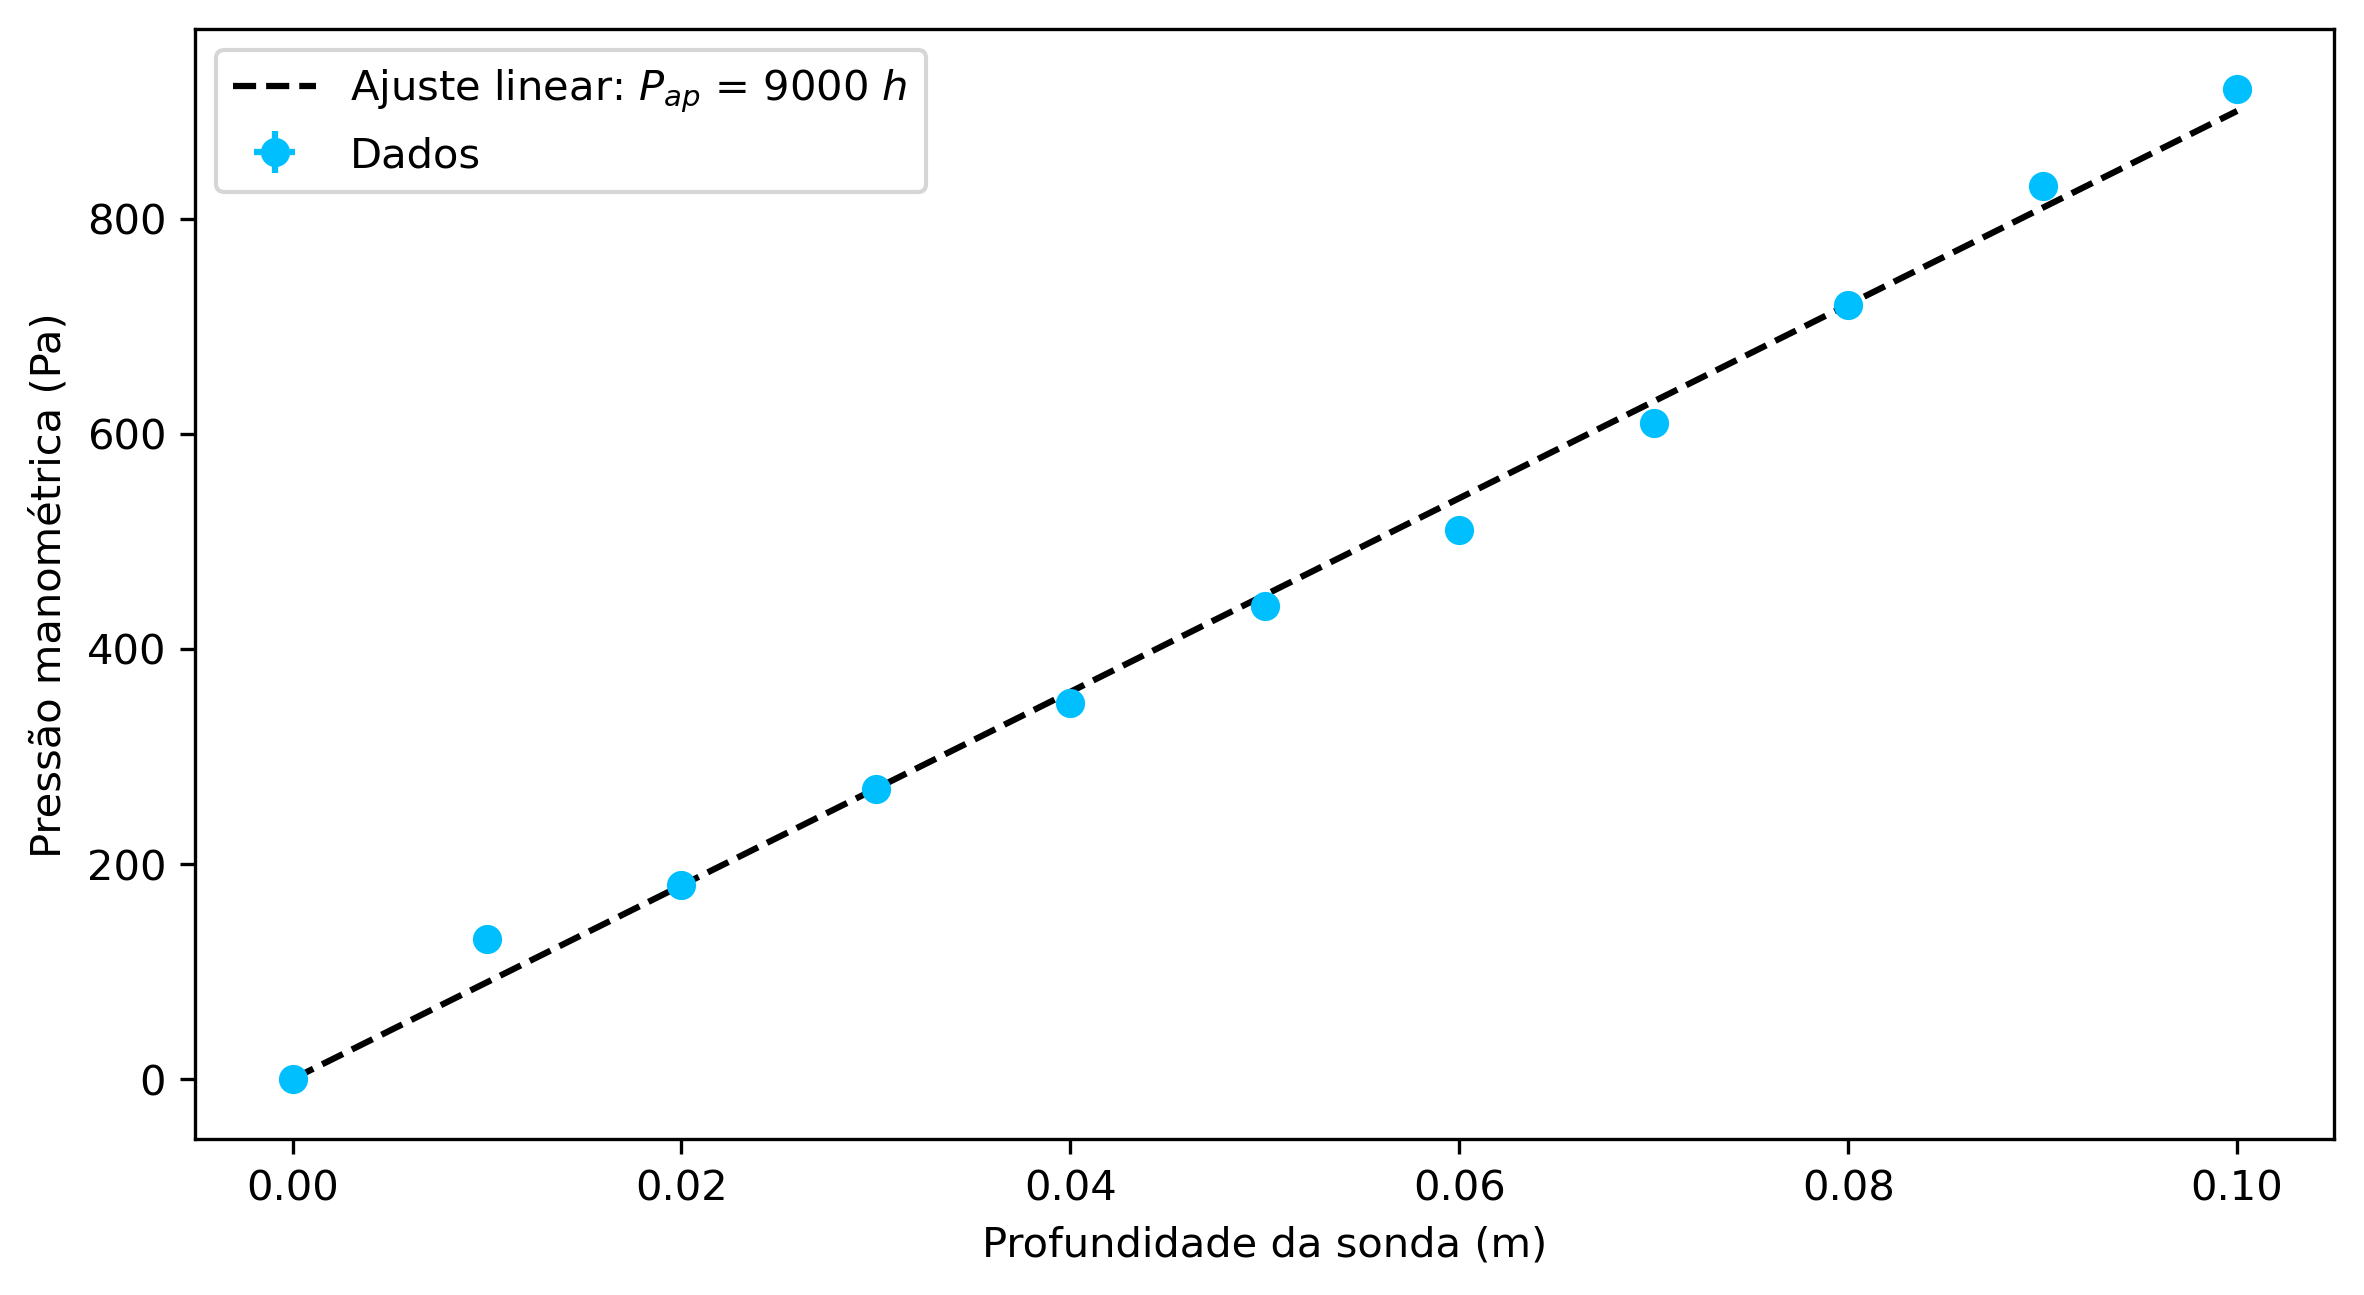

In [16]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(h,p_man,sigma_p_man_transf,0, 'o', color = 'deepskyblue', label = 'Dados')
plt.plot(h,h*coef_angular + coef_linear, color ='black', ls = '--', label = r'Ajuste linear: $P_{ap}$ = %.0f $h$ ' % (coef_angular))
plt.xlabel('Profundidade da sonda (m)')
plt.ylabel(r'Pressão manométrica (Pa)')
plt.legend()
plt.savefig('P_manxh_ajuste.pdf', dpi =300)
plt.show()

## Interpretação física do coeficiente angular

Segundo a lei de Stevin, a pressão manométrica é aquela gerada pela coluna de óleo de altura $h$:

$$p_{man} = p_{oleo}$$
$$p_{man} = \rho_o g h$$

Comparando com o ajuste linear $p_{man} = c \ h$ nós vemos que:

$$c = \rho_o g $$

Isolando a densidade do óleo:

$$\rho_o = \frac{c}{g}$$

A incerteza da densidade pode ser obtida através da porpagação do erro do coeficiente:

$$\sigma_{\rho_o} = \sqrt{\left(\frac{\partial }{\partial c}\frac{c}{g}\right)^2\sigma_{c}^2}$$
$$\sigma_{\rho_o} = \sqrt{\left(\frac{1}{g}\right)^2\sigma_{c}^2}$$
$$\sigma_{\rho_o} = \frac{\sigma_c}{g}$$

Vamos calular:

In [9]:
rho_o = np.round(coef_angular/g,-1)

sigma_rho_o = np.round(sigma_angular/g,-1)

print('rho_o = (%.0f +- %.0f) (kg/m^3)' % (rho_o,sigma_rho_o))

rho_o = (920 +- 20) (kg/m^3)


# Parte 2

In [10]:
#Dados

vazao = 0.3 #l/min
sigma_vazao = 0.04 #l/min

#mudando as unidades para o SI:
vazao = vazao/(60*1000) #m^3/s
sigma_vazao = sigma_vazao/(60*1000) #m^3/s

#Posição do topo da coluna de água no manômetro para o lado direito e esquerdo
y_d_97 = 132.5/1000 #m
y_e_97 = 89/1000 #m

y_d_75 = 214/1000 #m
y_e_75 = 35/1000 #m


## Calculando a diferença de pressão manométrica 9-7 e 9-5 de maneira análoga ao feito na parte 1 

In [11]:
#Calculando a altura da coluna de água no tubo direito que está acima da posição da água no tubo esquedo
delta_y_97 = y_d_97 - y_e_97
delta_y_75 = y_d_75 - y_e_75

#Calculando as diferenças de pressão
delta_p_97 = rho_a*g*delta_y_97
delta_p_75 = rho_a*g*delta_y_75

#Calculando a incerteza da diferença de pressão
sigma_delta_p_97 = sigma_delta_p_75 = float('{:g}'.format(float('{:.1g}'.format(rho_a*g*sigma_y*np.sqrt(2)))))

#Arredondando as diferenças de pressão segundo a incerteza
delta_p_97 = np.round(delta_p_97,0)
delta_p_75 = np.round(delta_p_75,0)

print('delta_p_97 = (%.0f +- %.0f) (Pa)' % (delta_p_97,sigma_delta_p_97))
print('delta_p_97 = (%.0f +- %.0f) (Pa)' % (delta_p_75,sigma_delta_p_75))


delta_p_97 = (426 +- 7) (Pa)
delta_p_97 = (1754 +- 7) (Pa)


## Calculando as velocidades pela equação da continuidade

Como a vazão $Q$ é mantida constante, a equação da continuidade nos diz que:

$$Q = A_i \ v_i$$

Onde $A_i$ é a área da seção reta do tubo $i$ e $v_i$ é a velocidade do fluido no tubo $i$. Isolando $v_i$:

$$v_i = \frac{Q}{A_i}$$

Por termos tubos cilíndricos de diâmetro $d_i$, então $A_i = \frac{\pi d_i^2}{4}$. Logo:

$$v_i = \frac{4Q}{\pi d_i^2}$$

A incerteza da velocidade pode ser obtida através da propagação do erro da vazão:

$$\sigma_{v_i} = \sqrt{\left(\frac{\partial}{\partial Q}\frac{4Q}{\pi d_i^2}\right)^2\sigma_Q^2}$$
$$\sigma_{v_i} = \sqrt{\left(\frac{4}{\pi d_i^2}\right)^2\sigma_Q^2}$$
$$\sigma_{v_i} = \frac{4\sigma_Q}{\pi d_i^2}$$

Nós temos os tubos 1,2 e 3, cujo os diâmetros da seção reta é $d_1 = 9 \ 10^{-3}$m, $d_2 = 5.2 \ 10^{-3}$m e $d_3 = 2.4 \ 10^{-3}$m. Logo, a velocidade nesses tubos será:

In [12]:
d_i = np.array([9e-3,5.2e-3,2.4e-3])
v_i = (4*vazao)/(np.pi*np.power(d_i,2)) 
sigma_v_i = [float('{:g}'.format(float('{:.1g}'.format(i)))) for i in ((4*sigma_vazao)/(np.pi*np.power(d_i,2)))]

for i,v in enumerate(v_i):
    if i == 2:
        print('v_%d = (%.1f +- %.1f) m/s' % (i,v,sigma_v_i[i]))
    else:
        print('v_%d = (%.2f +- %.2f) m/s' % (i,v,sigma_v_i[i]))


v_0 = (0.08 +- 0.01) m/s
v_1 = (0.24 +- 0.03) m/s
v_2 = (1.1 +- 0.1) m/s


## Aplicando a equação de Bernoulli para calcular a velocidade do fluido em um ponto

A equação de Bernoulli nos diz que:

$$P_A + \rho g y_A + \frac{1}{2}\rho v_A^2 = P_B + \rho g y_B + \frac{1}{2}\rho v_B^2$$

Para descobrirmos a velocidade no ponto $A$ basta o isolarmos na equação acima:

$$\frac{1}{2}\rho v_A^2 = (P_B-P_A) + \rho g (y_B-y_A) + \frac{1}{2}\rho v_B^2$$

Assumindo que os tubos não possuem diferença de altura:

$$\frac{1}{2}\rho v_A^2 = (P_B-P_A) + \frac{1}{2}\rho v_B^2$$

$$v_A^2 = \frac{2}{\rho}(P_B-P_A) +  v_B^2$$

Aplicando a equação da continuidade nós temos que $v_B = \frac{A_A}{A_B}v_A$. Logo:

$$v_A^2 \left[1 - \left(\frac{A_A}{A_B}\right)^2\right] = \frac{2}{\rho}(P_B-P_A) 2$$

$$v_A^2 \left[1 - \left(\frac{\frac{\pi d_A^2}{4}}{\frac{\pi d_B^2}{4}}\right)^2\right] = \frac{2}{\rho}(P_B-P_A) $$

$$v_A^2 \left[1 - \left(\frac{d_A}{d_B}\right)^4\right] = \frac{2}{\rho}(P_B-P_A) $$

$$v_i^2 = \frac{\frac{2}{\rho}(P_B-P_A) }{\left[1 - \left(\frac{d_A}{d_B}\right)^4\right] }$$

$$v_i = \sqrt{\frac{\frac{2}{\rho}(P_B-P_A) }{\left[1 - \left(\frac{d_A}{d_B}\right)^4\right] }}$$

Definindo ${\Delta P}_{BA} = P_B - P_A$:

$$v_A = \sqrt{\frac{\frac{2}{\rho}{\Delta P}_{BA} }{\left[1 - \left(\frac{d_A}{d_B}\right)^4\right] }}$$

Podemos calcular a incerteza associada a $v_A$ propagando o erro atrelado a $\Delta P_{BA}$:

$$\sigma_{v_A} = \bigg\vert\frac{d}{d\Delta P_{BA} }\sqrt{\frac{\frac{2}{\rho}{\Delta P}_{BA} }{\left[1 - \left(\frac{d_A}{d_B}\right)^4\right] }} \bigg\vert \sigma_{\Delta P_{BA}}$$
$$\sigma_{v_A} = \frac{1}{2\sqrt{\frac{\frac{2}{\rho}{\Delta P}_{BA} }{\left[1 - \left(\frac{d_A}{d_B}\right)^4\right] }}}
\frac{\frac{2}{\rho} }{\left[1 - \left(\frac{d_A}{d_B}\right)^4\right] }\sigma_{\Delta P_{BA}}$$

Utilizando que $v_A = \sqrt{\frac{\frac{2}{\rho}{\Delta P}_{BA} }{\left[1 - \left(\frac{d_A}{d_B}\right)^4\right] }}$:

$$\sigma_{v_A} = \frac{v_A}{2\Delta P_{BA}}\sigma_{\Delta P_{BA}}$$



In [27]:
v_b_1 = np.sqrt((2/rho_a * delta_p_97)/(1-np.power(d_i[1]/d_i[0],4)))
sigma_v_b_1 = float('{:g}'.format(float('{:.1g}'.format((v_b_1 * sigma_delta_p_97)/(2*delta_p_97)))))

v_b_2 = np.sqrt((2/rho_a * delta_p_75)/(1-np.power(d_i[2]/d_i[1],4)))
sigma_v_b_2 = float('{:g}'.format(float('{:.1g}'.format((v_b_2 * sigma_delta_p_75)/(2*delta_p_75)))))

print('v_5.2 = (%.3f +- %.3f)m/s' % (v_b_1,sigma_v_b_1))
print('v_2.4 = (%.3f +- %.3f) m/s' % (v_b_2,sigma_v_b_2))

v_5.2 = (0.979 +- 0.008)m/s
v_2.4 = (1.917 +- 0.004) m/s


## Aplicando a equação de Bernoulli para calcular a velocidade do fluido em um ponto

A equação de Bernoulli nos diz que:

$$P_i + \rho g y_i + \frac{1}{2}\rho v_i^2 = P_j + \rho g y_j + \frac{1}{2}\rho v_j^2$$

Para descobrirmos a velocidade no ponto $i$ basta o isolarmos na equação acima:

$$\frac{1}{2}\rho v_i^2 = (P_j-P_i) + \rho g (y_j-y_i) + \frac{1}{2}\rho v_j^2$$

Assumindo que os tubos não possuem diferença de altura:

$$\frac{1}{2}\rho v_i^2 = (P_j-P_i) + \frac{1}{2}\rho v_j^2$$

$$v_i^2 = \frac{2}{\rho}(P_j-P_i) +  v_j^2$$

Definindo ${\Delta P}_{ij}$ = P_j-P_i$:

$$v_i = \sqrt{\frac{2}{\rho}{\Delta P}_{ij} +  v_j^2}$$

A incerteza de $v_i$ pode ser obtida propagação dos erros de${\Delta P}_{ij}$ e $v_j$:

$$\sigma_{v_i} = \sqrt{\left(\frac{\partial}{\partial {\Delta P}_{ij}}\sqrt{\frac{2}{\rho}{\Delta P}_{ij} +  v_j^2}\right)^2\sigma_{{\Delta_P} {ij}}^2 + \left(\frac{\partial}{\partial v_j}\sqrt{\frac{2}{\rho}{\Delta_P} {ij} +  v_j^2}\right)^2\sigma_{v_j}^2}$$

$$\sigma_{v_i} = \frac{1}{2\sqrt{\frac{2}{\rho}{\Delta P}_{ij} +  v_j^2}} \sqrt{\left(\frac{2}{\rho} \right)^2\sigma_{{\Delta P}_{ij}}^2 + \left(   2v_j\right)^2\sigma_{v_j}^2}$$

Utilizando que $v_i = \sqrt{\frac{2}{\rho}{\Delta P}_{ij} +  v_j^2}$:

$$\sigma_{v_i} = \frac{1}{2v_i} \sqrt{\left(\frac{2}{\rho} \right)^2\sigma_{{\Delta P}_{ij}}^2 + \left(   2v_j\right)^2\sigma_{v_j}^2}$$

Para calcularmos a velocidade do tubo $i=1$ a partir do tubo $j=0$ nós podemos utilizar ${\Delta_p}_{97}$ e que $v_0 = 0.08$:

$$v_1 = \sqrt{\frac{2}{\rho}{\Delta P}_{10} +  v_0^2}$$

Como ${\Delta P}_{10} ={\Delta P}_{97}$:

$$v_1 = \sqrt{\frac{2}{\rho}{\Delta P}_{97} +  v_0^2}$$

E sua incerteza será:

$$\sigma_{v_1} = \frac{1}{2v_1} \sqrt{\left(\frac{2}{\rho} \right)^2\sigma_{{\Delta P}_{97}}^2 + \left(   2v_0\right)^2\sigma_{v_0}^2}$$

In [14]:
v_b_1 = np.sqrt(2/rho_a * delta_p_97 + v_i[0]**2)
sigma_v_b_1 = 1/(2*v_b_1) * np.sqrt(np.power(2*sigma_delta_p_97/rho_a,2) + np.power(2*v_i[0]*sigma_v_i[0],2))
sigma_v_b_1 = float('{:g}'.format(float('{:.1g}'.format(sigma_v_b_1))))
print('v_b_1 = (%.3f +- %.3f) (m/s)' % (v_b_1,sigma_v_b_1))

v_b_1 = (0.926 +- 0.008) (m/s)


Fazendo o processo análogo porém com $i=2$ e $j=1$

In [15]:
v_b_2 = np.sqrt(2/rho_a * delta_p_75 + v_b_1**2)
sigma_v_b_2 = 1/(2*v_b_2) * np.sqrt(np.power(2*sigma_delta_p_75/rho_a,2) + np.power(2*v_b_1*sigma_v_b_1,2))
sigma_v_b_2 = float('{:g}'.format(float('{:.1g}'.format(sigma_v_b_2))))
print('v_b_1 = (%.3f +- %.3f) (m/s)' % (v_b_2,sigma_v_b_2))

v_b_1 = (2.090 +- 0.005) (m/s)
